In [95]:
import boto3
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import sagemaker
import time
import sagemaker
import pandas as pd
from sagemaker import get_execution_role
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
from IPython.display import display, HTML
import random
import matplotlib.image as mpimg
import io
from PIL import Image
import requests
from sagemaker.feature_store.feature_definition import FeatureDefinition, FeatureTypeEnum
from sagemaker.feature_store.feature_group import FeatureGroup
from time import gmtime, strftime
import boto3
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import sagemaker
from sagemaker.estimator import Estimator

In [6]:
# Create S3 Bucket
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)

In [7]:
print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-284000663973


In [10]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [11]:
s3_private_path = "s3://{}/data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-284000663973/data


In [13]:
!aws s3 cp "./data" $s3_private_path/ --recursive

upload: data/benign/1003.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1003.jpg
upload: data/benign/1013.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1013.jpg
upload: data/benign/1.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1.jpg  
upload: data/benign/10.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/10.jpg
upload: data/benign/1018.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1018.jpg
upload: data/benign/1033.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1033.jpg
upload: data/benign/1061.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1061.jpg
upload: data/benign/1006.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1006.jpg
upload: data/benign/1055.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1055.jpg
upload: data/benign/1023.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1023.jpg
upload: data/benign/1070.jpg to s3://sagemaker-us-east-1-284000663973/data/benign/1070.jpg
upload:

In [15]:
!aws s3 ls $s3_private_path/

                           PRE benign/
                           PRE malignant/


In [16]:
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-{}/data/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

# EDA

Class distribution:
label
malignant    1130
benign        755
Name: count, dtype: int64


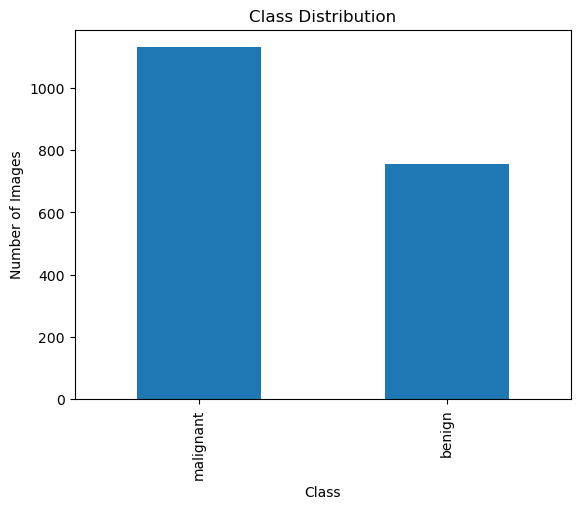

In [26]:
data_prefix = "data/"  # Ensure this points to the root of your data folder

# Create a client to interact with S3
s3 = boto3.client('s3')

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Initialize pagination for listing all objects
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket, Prefix=data_prefix)

# Collect image file paths and labels based on S3 keys
for page in pages:
    for obj in page.get('Contents', []):
        if obj['Key'].endswith('.jpg') or obj['Key'].endswith('.png'):
            image_path = f"s3://{bucket}/{obj['Key']}"
            image_paths.append(image_path)
            
            # Assuming folder structure is data/class_name/image.jpg
            label = obj['Key'].split('/')[-2]
            labels.append(label)

# Create a DataFrame to store image paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Check the distribution of classes
class_distribution = df['label'].value_counts()
print("Class distribution:")
print(class_distribution)

# Plot the class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

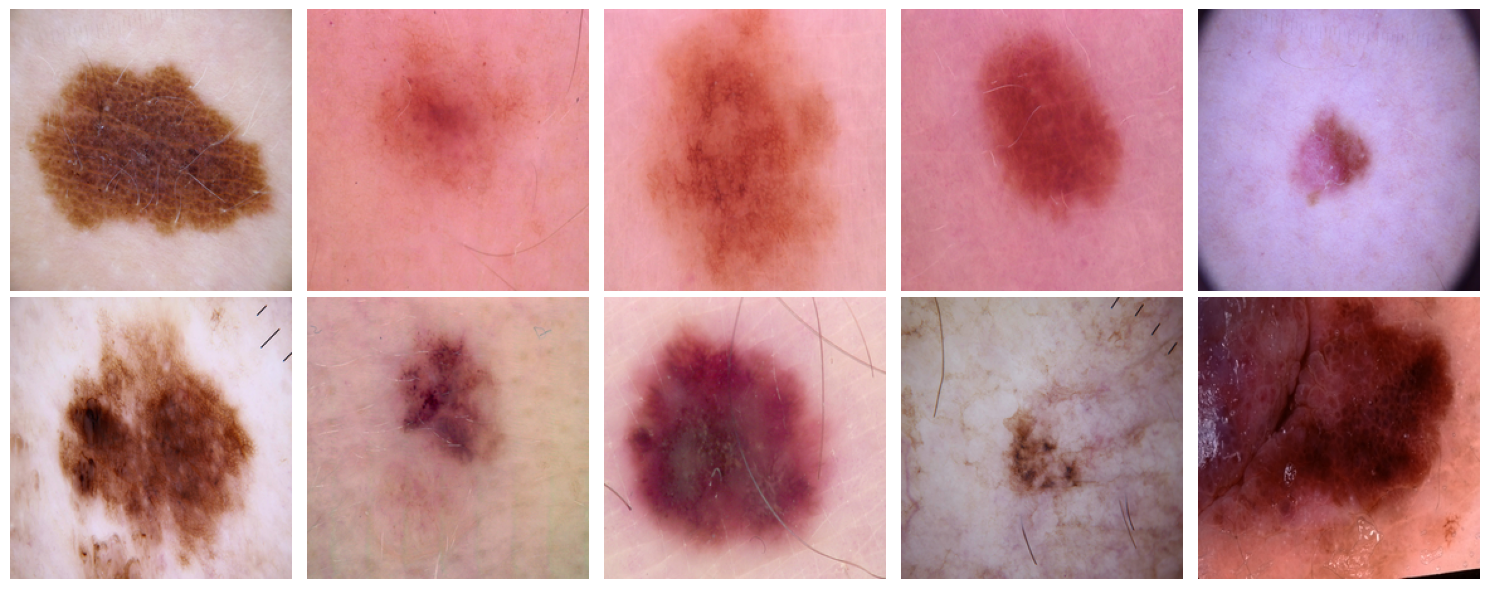

In [27]:
# Use boto3 to access the S3 images
s3 = boto3.client('s3')

def load_image_from_s3(s3_url):
    # Parse the S3 URL
    bucket_name = s3_url.split('/')[2].split('.')[0]
    key = '/'.join(s3_url.split('/')[3:])

    # Get the image object from S3
    obj = s3.get_object(Bucket=bucket_name, Key=key)
    
    # Read the image content and return it as an Image object
    img_data = obj['Body'].read()
    img = Image.open(io.BytesIO(img_data))
    
    return img

def show_sample_images(df, num_samples=5):
    classes = df['label'].unique()
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(num_samples*3, len(classes)*3))

    for i, cls in enumerate(classes):
        cls_df = df[df['label'] == cls]
        samples = cls_df.sample(num_samples)
        for j, (_, row) in enumerate(samples.iterrows()):
            img = load_image_from_s3(row['image_path'])  # Load image from S3
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_ylabel(cls, size='large')

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(df)

# Feature Engineering | Feature Store | Feature Group

In [84]:
# Define the feature group
feature_group_name = 'skin-cancer-feature-group' + strftime('%d-%H-%M-%S', gmtime())
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

# Function to extract features from each image
def extract_features(row):
    # Read image from S3
    key_path = '/'.join(row['image_path'].split('/')[3:])
    s3_object = s3.get_object(Bucket=bucket, Key=key_path)
    img = Image.open(io.BytesIO(s3_object['Body'].read()))
    img_array = np.array(img)

    # Extract image features
    height, width = img.size
    mean_pixel_value = img_array.mean()

    return pd.Series({
        'image_path': row['image_path'],
        'label': row['label'],
        'height': height,
        'width': width,
        'mean_pixel_value': mean_pixel_value
    })

# Assume df is your initial DataFrame containing the image paths and labels
features_df = df.apply(extract_features, axis=1)

# Set up event time and record identifier
record_identifier_name = 'image_path'
event_time_feature_name = 'event_time'

# Ensure the event time is in the correct ISO-8601 format with timezone
features_df[event_time_feature_name] = pd.to_datetime('now', utc=True).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'

# Create the feature group
feature_group.load_feature_definitions(data_frame=features_df)

# Create the feature group in SageMaker Feature Store
feature_group.create(
    s3_uri=f's3://{bucket}/{data_prefix}/feature-store',
    record_identifier_name=record_identifier_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True
)

# Function to check the status of the feature group
def wait_for_feature_group_creation(feature_group):
    status = 'Creating'
    while status not in ['Created', 'CreateFailed']:
        description = feature_group.describe()
        status = description['FeatureGroupStatus']
        if status == 'Created':
            print(f"Feature group '{feature_group_name}' successfully created.")
            break
        elif status == 'CreateFailed':
            raise Exception(f"Feature group '{feature_group_name}' creation failed.")
        print(f"Waiting for feature group '{feature_group_name}' creation. Current status: {status}")
        time.sleep(10)  # Check every 10 seconds

# Wait for the feature group to be created
wait_for_feature_group_creation(feature_group)

# Ingest the DataFrame directly into the Feature Store
feature_group.ingest(data_frame=features_df, max_workers=5, wait=True)

print(f"Features successfully ingested into Feature Group: {feature_group_name}")


Waiting for feature group 'skin-cancer-feature-group13-00-24-10' creation. Current status: Creating
Waiting for feature group 'skin-cancer-feature-group13-00-24-10' creation. Current status: Creating
Waiting for feature group 'skin-cancer-feature-group13-00-24-10' creation. Current status: Creating
Waiting for feature group 'skin-cancer-feature-group13-00-24-10' creation. Current status: Creating
Feature group 'skin-cancer-feature-group13-00-24-10' successfully created.
Features successfully ingested into Feature Group: skin-cancer-feature-group13-00-24-10


# Benchmark Model

In [85]:
from sklearn.model_selection import train_test_split

# First, split off production data (40%)
train_val_df, prod_df = train_test_split(features_df, test_size=0.4, stratify=features_df['label'], random_state=42)

# Then split the remaining data
train_df, temp_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Verify the splits
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"Production set: {len(prod_df)} samples")


Training set: 904 samples
Validation set: 113 samples
Test set: 114 samples
Production set: 754 samples


In [89]:
# Select simple features
benchmark_features = ['mean_pixel_value']

# Prepare datasets
X_train = train_df[benchmark_features]
y_train = train_df['label']

X_val = val_df[benchmark_features]
y_val = val_df['label']

X_test = test_df[benchmark_features]
y_test = test_df['label']

In [90]:
# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Train logistic regression benchmark model
benchmark_model = LogisticRegression()
benchmark_model.fit(X_train, y_train_enc)

# Evaluate on validation set
val_score = benchmark_model.score(X_val, y_val_enc)
print(f"Validation Accuracy of Benchmark Model: {val_score}")

Validation Accuracy of Benchmark Model: 0.5929203539823009


In [97]:
# Save the train, validation, and test datasets to CSV files
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Upload datasets to S3
s3 = boto3.resource('s3')
s3_train_path = f's3://{bucket}/data/train/train.csv'
s3_val_path = f's3://{bucket}/data/validation/validation.csv'
s3_test_path = f's3://{bucket}/data/test/test.csv'

s3.Bucket(bucket).Object('data/train/train.csv').upload_file('train.csv')
s3.Bucket(bucket).Object('data/validation/validation.csv').upload_file('validation.csv')
s3.Bucket(bucket).Object('data/test/test.csv').upload_file('test.csv')

# Use the built-in XGBoost container
xgboost_container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, version="1.5-1")

xgboost_estimator = Estimator(
    image_uri=xgboost_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/data/output',
    hyperparameters={
        'objective': 'binary:logistic',
        'num_round': 100
    }
)

# Start training with the S3 datasets
xgboost_estimator.fit({'train': s3_train_path, 'validation': s3_val_path})

print("XGBoost model training completed.")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-13-00-37-06-924


2024-10-13 00:37:07 Starting - Starting the training job...
2024-10-13 00:37:22 Starting - Preparing the instances for training...
2024-10-13 00:37:49 Downloading - Downloading input data......
2024-10-13 00:38:39 Downloading - Downloading the training image...
2024-10-13 00:39:30 Training - Training image download completed. Training in progress../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-10-13 00:39:35.842 ip-10-2-203-240.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-13 00:39:35.866 ip-10-2-203-240.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-13:00:39:36:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-13:00:39:36:INFO] Failed to parse hyperparameter objective value bina

UnexpectedStatusException: Error for Training job sagemaker-xgboost-2024-10-13-00-37-06-924: Failed. Reason: AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_containers/_trainer.py", line 84, in train
    entrypoint()
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/training.py", line 102, in main
    train(framework.training_env())
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/training.py", line 98, in train
    run_algorithm_mode()
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/training.py", line 64, in run_algorithm_mode
    sagemaker_train(
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/algorithm_mode/train.py", line 198, in sagemaker_train
    train_dmatrix, val_dmatrix, train_val_dmatrix = get_validated_dmatrices(
  File "/miniconda3/lib/python3.8/site-packages/sagemaker_xgboost_container/algorithm_mode/train.py", line 78, in get_validated_dmatrices
    validate_data_file_path(train_path, content_type)
  File "/miniconda

In [ ]:
%%writefile training_script.py

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import argparse
import os

def main(args):
    # Data loading and preprocessing logic here
    # ...

    # Build the model
    model = Sequential([
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training logic here
    # ...

    # Save the model
    model.save(os.path.join(args.model_dir, 'model.h5'))

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters and directories
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    args = parser.parse_args()
    main(args)


In [ ]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(entry_point='training_script.py',
                       role=role,
                       instance_count=1,
                       instance_type='ml.p2.xlarge',
                       framework_version='2.4',
                       py_version='py37',
                       hyperparameters={
                           'epochs': 10
                       })

estimator.fit({'train': s3_train_path, 'validation': s3_val_path})


# Evaluate Model and Compare Against Benchmark Model

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')


In [ ]:
# Assuming test images are accessible and preprocessed
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    return img_array

# Get test image paths and labels
test_image_paths = test_df['image_path'].values
test_labels = le.transform(test_df['label'].values)


In [ ]:
from sklearn.metrics import accuracy_score

predictions = []
for img_path in test_image_paths:
    img_array = preprocess_image(img_path)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    pred = predictor.predict(img_array)['predictions']
    predicted_class = np.argmax(pred)
    predictions.append(predicted_class)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, predictions)
print(f"Test Accuracy of SageMaker Model: {test_accuracy}")


In [ ]:
benchmark_test_score = benchmark_model.score(X_test, y_test_enc)
print(f"Test Accuracy of Benchmark Model: {benchmark_test_score}")

# Comparison
improvement = test_accuracy - benchmark_test_score
print(f"Accuracy Improvement over Benchmark: {improvement}")


# Deploy Model

In [ ]:
transformer = estimator.transformer(instance_count=1, instance_type='ml.m5.xlarge')
transformer.transform(s3_test_path, content_type='text/csv', split_type='Line')
transformer.wait()


# Model Monitoring and Reports

In [ ]:
# TODO

'''
Implement model monitors on your ML system.
Implement data monitors on your ML system.
Implement infrastructure monitors on your ML system.
Create a monitoring dashboard for your ML endpoint/job on Cloudwatch
Generate model and data reports on SageMaker.
Update and post the tracker to the Team Project Update.


In [4]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat
from datetime import datetime, timedelta, timezone
import json
import os
import re
import boto3
from time import sleep
from threading import Thread

import pandas as pd

from sagemaker import get_execution_role, session, Session, image_uris
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer

from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig

In [5]:

session = Session()
# Get Execution role
role = get_execution_role()
print("RoleArn:", role)

region = session.boto_region_name
print("Region:", region)

RoleArn: arn:aws:iam::001188301630:role/LabRole
Region: us-east-1


In [6]:
# Create the model quality monitoring object
churn_model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session,
)

In [7]:
baseline_job_name = f"malignant-cancerous-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"


# CI/CD